<a href="https://colab.research.google.com/github/samuelmacko/master_thesis/blob/master/data_preprocessing_and_models/thesis_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## csv to IDs

In [ ]:
! pip install pygithub

     |████████████████████████████████| 296kB 12.1MB/s 


In [ ]:
from csv import reader
from marshal import dump, load
from typing import Any, List, Optional, Set

import github
from github.GithubException import UnknownObjectException

In [ ]:
def save_visited_ids(dat_file: str, ids_set: Set[int]) -> None:
    with open(file=dat_file, mode='wb') as f:
        dump(ids_set, f)

def load_visited_ids(dat_file: str) -> Optional[Set[int]]:
    with open(file=dat_file, mode='rb') as f:
        return load(f)


In [ ]:
repo_names: Set[str] = set()

with open(
    file='/content/drive/MyDrive/thesis/datasets/maintained.csv_2021-03-17-21:22:12'
) as maintained_csv:
    csv_reader = reader(maintained_csv)
    for row in csv_reader:
        repo_names.add(row[0])

In [ ]:
repo_ids: Set[int] = set()
error_names = set()
g = Github(login_or_token='7da8f4fe8d6e50e96ace86a688e12cda92064bde')

for repo_name in repo_names:
    try:
        repo = g.get_repo(full_name_or_id=repo_name)
        repo_ids.add(repo.id)
    except UnknownObjectException as e:
        error_names.add(repo_name)
        continue

In [ ]:
maintained_ids = load_visited_ids(
    dat_file='/content/drive/MyDrive/thesis/datasets/maintained_ids.dat_2021-03-23-15:54:02'
)

In [ ]:
maintained_ids = maintained_ids.union(repo_ids)

In [ ]:
save_visited_ids(
    dat_file='/content/drive/MyDrive/thesis/datasets/maintained_ids.dat_2021-03-23-16:54:02',
    ids_set=maintained_ids
)

## Statistics

In [ ]:
g = github.Github(login_or_token='7da8f4fe8d6e50e96ace86a688e12cda92064bde')
# g = Github()

In [ ]:
def unmaintained_in_readme(repo: github.Repository) -> bool:
    keywords_list = [
        'deprecated', 'unmaintained', 'no longer maintained',
        'no longer supported', 'no longer under development',
        'not maintained', 'not under development', 'obsolete', 'archived'
    ]
    readme = repo.get_readme().decoded_content.decode("utf-8")
    return any(keyword in readme for keyword in keywords_list)

In [ ]:
repos_with_unmaintained_in_readme = set()

for repo_name in unmaintained_df['repo_name']:
    try:
        repo = g.get_repo(full_name_or_id=repo_name)

        if unmaintained_in_readme(repo=repo):
            repos_with_unmaintained_in_readme.add(repo.url)
    except UnknownObjectException:
        continue

In [ ]:
url = ''

for repo_url in repos_with_unmaintained_in_readme:
    url = repo_url.replace('https://api.', '')
    url = url.replace('/repos', '')
    print(url)

github.com/pflnh/iCarousel
github.com/paulgeringer/jenkins_api_client
github.com/jbremond/pyload-freebsd
github.com/Karyotyper/jquery
github.com/gerapeldoorn/puppetlabs-apache
github.com/yannan/TouchSwipe-Jquery-Plugin
github.com/hschottm/MatchMemoPool
github.com/qjcg/python_koans
github.com/chenrui2014/ActionBarSherlock
github.com/lassefs/javascript-state-machine
github.com/zhtengw/nixnote2
github.com/eins78/canned
github.com/johnbk/bootstrap3-wysihtml5-bower
github.com/panwang/OpenUDID
github.com/ProPuke/nodejs-std
github.com/eveevans/active_merchant
github.com/stefano-garzarella/ompi-release
github.com/dingjoey/storm
github.com/sergey-shambir/cocos2d-x
github.com/polmiro/active_model_serializers
github.com/linkinwong/.emacs.d
github.com/rightscale/rest_connection
github.com/aleron75-archive/Webgriffe_TphPro


__maintained repository classified as unmaintained:__ github.com/hschottm/MatchMemoPool

In [ ]:
repo_dict = {}
error_names = set()

for id in maintained_ids:
    try:
        repo = g.get_repo(full_name_or_id=id)
        repo_dict[str(id)] = repo.get_commits()[0].last_modified
    except UnknownObjectException as e:
        error_names.add(repo_name)
        continue

In [ ]:
repo_dict

In [ ]:
r = g.get_repo(3003195)

In [ ]:
r.get_commits()[0].last_modified

'Mon, 15 Sep 2014 19:09:26 GMT'

In [ ]:
r.url

'https://api.github.com/repos/gbenison/starparse'

# Preprocessing

## Methods

In [ ]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

In [ ]:
def transform_dataframe(dataset: pd.DataFrame) -> np.ndarray:
    all_cols_to_drop = ['repo_name', 'url']
    all_cols_to_encode = [
        'owner_type', 'has_test', 'has_doc', 'has_example', 'has_readme'
    ]

    cols_to_drop = [
        col for col in all_cols_to_drop if col in dataset.columns
    ]
    cols_to_encode = [
        col for col in all_cols_to_encode if col in dataset.columns
    ]
    cols_to_scale = [
        col for col in dataset.columns if (
            col not in cols_to_encode and col not in cols_to_drop
        )
    ]

    transformer = ColumnTransformer([
        ('OHE', OneHotEncoder(), cols_to_encode),
        # ('RobustScaler', RobustScaler(), cols_to_scale)
        ('StScaler', StandardScaler(), cols_to_scale)
    ])

    return transformer.fit_transform(dataset)

def correlated_columns(dataset: pd.DataFrame, threshold: float) -> list:
    corr_matrix = dataset.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
    )

    correlated_columns = [
        col for col in upper_triangle.columns
        if any(upper_triangle[col] > threshold)
    ]
    return correlated_columns

## Load data

In [ ]:
maintained_df: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/thesis/datasets/maintained.csv_2021-03-27-09 18 43'
)
maintained_df.shape

(125, 30)

In [ ]:
unmaintained_df: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/thesis/datasets/unmaintained.csv_2021-03-30-09 41 31'
)
unmaintained_df.shape

(603, 30)

### Correlated columns

In [ ]:
from matplotlib import rcParams
import seaborn as sns

rcParams['figure.figsize'] = 10, 10

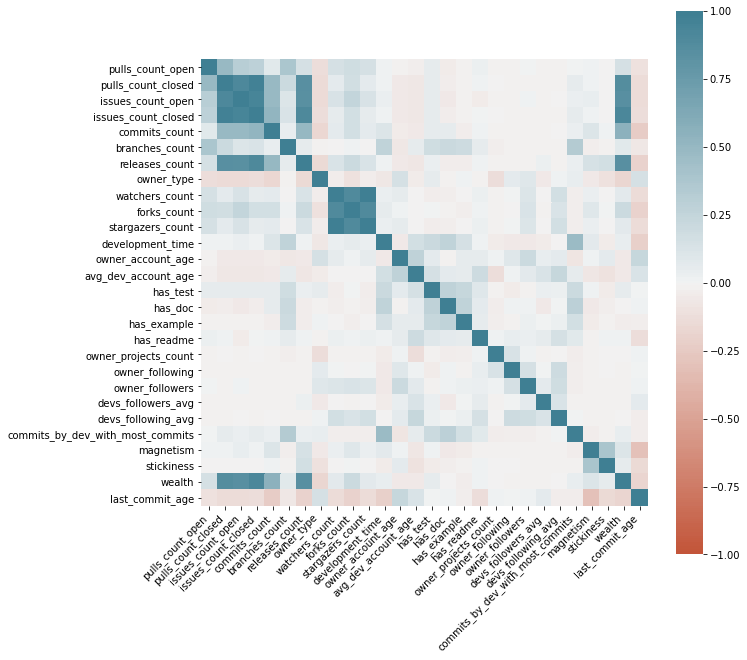

In [ ]:
ax = sns.heatmap(
    unmaintained_df.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    xticklabels=True, yticklabels=True, square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment='right'
);

In [ ]:
correlated_cols = correlated_columns(dataset=unmaintained_df, threshold=0.9)

maintained_df = maintained_df.drop(columns=correlated_cols)
unmaintained_df = unmaintained_df.drop(columns=correlated_cols)

maintained_df.shape, unmaintained_df.shape

((125, 25), (603, 25))

In [ ]:
correlated_cols

['issues_count_open',
 'issues_count_closed',
 'releases_count',
 'stargazers_count',
 'wealth']

# Compute centroid

In [ ]:
def compute_centroid(dataset: np.ndarray) -> np.ndarray:
    model = KMeans(n_clusters=1)
    model.fit(X=dataset)
    return model.cluster_centers_

In [ ]:
maintained_tr = transform_dataframe(dataset=maintained_df)

centroid = compute_centroid(dataset=maintained_tr)

## Maintained outlier and centroid visualization - __unused__

In [ ]:
maintained_tr.shape

(125, 28)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [ ]:
def remove_outliers(X: np.ndarray) -> np.ndarray:
    clf = IsolationForest(contamination=0.3).fit(X=X)
    outliers = clf.predict(X=X)
    mask = outliers < 0
    return X[~mask]

In [ ]:
a = np.append(maintained_tr_out, centroid, axis=0)

NameError: ignored

In [ ]:
(remove_outliers(X_train)).shape

In [ ]:
X_train.shape

In [ ]:
X_train_reduced.shape

In [ ]:
pca = PCA(n_components=2)

# maintained_reduced = pca.fit_transform(X=maintained_tr_out)
# maintained_reduced = pca.fit_transform(X=a)
X_train_reduced = pca.fit_transform(X=remove_outliers(X_train))

In [ ]:
# plt.scatter(x=maintained_reduced[:,0], y=maintained_reduced[:,1], alpha=0.5)
# plt.scatter(x=maintained_reduced[-1,0], y=maintained_reduced[-1,1], alpha=0.5, color='red')
plt.scatter(x=X_train_reduced[:, 0], y=X_train_reduced[:, 1], alpha=0.5)
plt.show()

# Prepare unmaintained data

## Split

In [ ]:
X_train_df, X_test_df = train_test_split(
    unmaintained_df, test_size=0.2, random_state=2
)

X_train = transform_dataframe(dataset=X_train_df)
X_test = transform_dataframe(dataset=X_test_df)

X_train.shape, X_test.shape

((482, 28), (121, 28))

## Label

In [ ]:
from typing import Union

In [ ]:
def create_labels(X: np.ndarray, centroid: np.ndarray) -> np.ndarray:
    distances = pairwise_distances(X=X, Y=centroid, metric='l2')
    distances = distances.reshape(distances.shape[0], 1)
    X_d = np.append(arr=X, values=distances, axis=1)

    lower_bound, upper_bound = outlier_ranges(dataset=distances)
    X_r = X_d[
        (X_d[:, X_d.shape[1] - 1] > lower_bound) & \
        (X_d[:, X_d.shape[1] - 1] < upper_bound)
    ]

    _, edges = np.histogram(a=X_r[:, -1], bins=10)

    for i in range(X_d.shape[0]):
        distance = X_d[i, -1]
        label = np.searchsorted(a=edges, v=distance, side='left')
        if label == 0:
            label = 1
        if label > 10:
            label = 10

        X_d[i, X_d.shape[1] - 1] = label

    return X_d[:, :-1], X_d[:, -1]

def outlier_ranges(dataset: np.ndarray) -> Union[float, float]:
    dataset.sort()
    Q1, Q3 = np.percentile(dataset, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)

    return lower_range, upper_range

In [ ]:
X_train, y_train = create_labels(X=X_train, centroid=centroid)
X_test, y_test = create_labels(X=X_test, centroid=centroid)

### Visulalizations

In [ ]:
# plt.hist(y_train, bins=10)

In [ ]:
# plt.hist(y_test, bins=10)

# Training

## Parameters for grid search

In [ ]:
from typing import Dict, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [ ]:
randomforest_parameters = {
    # # 'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    # 'n_estimators': [x for x in range(100, 600, 100)],
    # 'max_features': ['auto', 'sqrt'],
    # # 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    # # 'max_depth': [int(x) for x in np.linspace(10, 50, num = 11)] + [None],
    # 'max_depth': [x for x in range(10, 60, 10)] + [None],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

SVC_parameters = {
    # 'C': [0.1, 1, 10, 100, 1000],
    # 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

kNN_parameters = {
    # 'n_neighbors': [1, 10, 1],
    # 'leaf_size': [20, 40, 1],
    # 'p': [1, 2],
    # 'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'chebyshev']
}

MLP_parameters = {
    # 'batch_size': [25, 32],
    'max_iter': [100, 500],
    'solver': ['sgd', 'adam', 'lbfgs']
}

models_and_parameters = [
    ('RandomForest', RandomForestClassifier(), randomforest_parameters),
    # ('SVC', SVC(), SVC_parameters),
    # ('kNN', KNeighborsClassifier(), kNN_parameters),
    # ('MLP', MLPClassifier(), MLP_parameters)
]

## Grid search

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
keys_to_remove = [
    'params', 'param_solver', 'param_max_iter', 'mean_fit_time',
    'mean_score_time', 'std_fit_time', 'std_score_time',
    'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'
]
keys_to_remove += [f'split{i}_test_accuracy' for i in range(0, 5)]
keys_to_remove += [f'split{i}_test_precision_macro' for i in range(0, 5)]
keys_to_remove += [f'split{i}_test_recall_macro' for i in range(0, 5)]

def process_results(
    results: Dict[str, np.ndarray], keys_to_remove: List[str]
) -> pd.DataFrame:
    keys = list(results.keys())

    for key in keys:
        if key in keys_to_remove:
            del results[key]

    return pd.DataFrame(data=results)

In [ ]:
randomforest_parameters

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}

In [ ]:
def approx_score(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    correct = 0
    size = y_true.size

    for i in range(size):
        if y_true[i] == y_predicted[i] or y_true[i] == y_predicted[i] + 1 or \
            y_true[i] == y_predicted[i] - 1:
            correct += 1

    return correct / size

In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'approx': make_scorer(approx_score)
}

results_dict = {}

for mp in models_and_parameters:
    clf = GridSearchCV(
        # estimator=mp[1], param_grid=mp[2], scoring=scoring, refit=False
        estimator=mp[1], param_grid=mp[2], scoring=scoring, refit='accuracy'
    )
    clf.fit(X=X_train, y=y_train)

    # results_dict[mp[0]] = process_results(
    #     results=clf.cv_results_, keys_to_remove=keys_to_remove
    # )

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.18733449, 0.28023882]),
 'mean_score_time': array([0.00959277, 0.0095942 ]),
 'mean_test_accuracy': array([0.65985825, 0.62661082]),
 'mean_test_special_scorer': array([0.82996134, 0.79254725]),
 'param_criterion': masked_array(data=['gini', 'entropy'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'criterion': 'gini'}, {'criterion': 'entropy'}],
 'rank_test_accuracy': array([1, 2], dtype=int32),
 'rank_test_special_scorer': array([1, 2], dtype=int32),
 'split0_test_accuracy': array([0.62886598, 0.6185567 ]),
 'split0_test_special_scorer': array([0.81443299, 0.77319588]),
 'split1_test_accuracy': array([0.63917526, 0.60824742]),
 'split1_test_special_scorer': array([0.80412371, 0.80412371]),
 'split2_test_accuracy': array([0.625, 0.625]),
 'split2_test_special_scorer': array([0.79166667, 0.76041667]),
 'split3_test_accuracy': array([0.70833333, 0.65625   ]),
 'split3_test_special_scorer': array([0.90625   

In [ ]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
clf.cv_results_['mean_test_score'].mean()
# type(clf.cv_results_['params'])
# clf.cv_results_['std_test_score']

0.6057290321764006

In [ ]:
# len(clf.cv_results_['params'])
len(clf.cv_results_['mean_test_score'])

2160

In [ ]:
results_dict['MLP']

# Results

## Baselines

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Stratified

In [ ]:
baseline_stratified_clf = DummyClassifier(strategy='stratified')
baseline_stratified_clf.fit(X=X_train, y=y_train)

y_pred = baseline_stratified_clf.predict(X=X_train)
accuracy_score(y_true=y_train, y_pred=y_pred)

0.24688796680497926

### Most frequent

In [ ]:
baseline_most_frequent_clf = DummyClassifier(strategy='most_frequent')
baseline_most_frequent_clf.fit(X=X_train, y=y_train)

y_pred = baseline_most_frequent_clf.predict(X=X_train)
accuracy_score(y_true=y_train, y_pred=y_pred)

0.35269709543568467